In [1]:
import sys
sys.path.append('../../..')
import cortexetl as c_etl

In [2]:
ma2 = c_etl.analysis_initial_processing("8-FRDistributionTest-0-Test.yaml", loglevel="ERROR")
# ma2 = c_etl.analysis_initial_processing("neuropixels_lfp_10m_384ch_hex0_40Khz_2023_10_18.yaml", loglevel="ERROR")
a2_hex0 = ma2.hex0_spikes
c_etl.post_analysis(a2_hex0)
a = a2_hex0


----- Custom post analysis -----
Custom post analysis:  2
Custom post analysis:  1
Custom post analysis:  3
Custom post analysis:  8
Custom post analysis:  13
Custom post analysis:  11
Custom post analysis:  18
Custom post analysis:  6
Custom post analysis:  16
----- Custom post analysis complete: 24.11s -----


0.3


/nvme/isbister/2720688/ipykernel_4628/4198958346.py:157: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


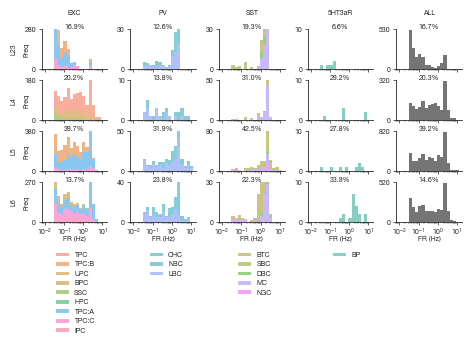

0.7


/nvme/isbister/2720688/ipykernel_4628/4198958346.py:157: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


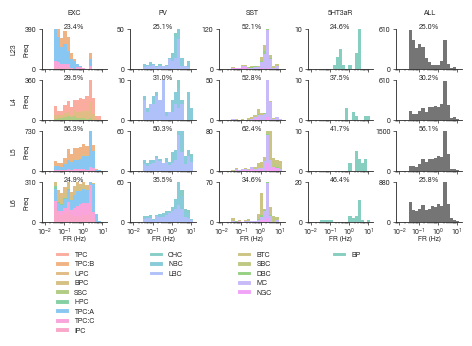

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# figsize=(3.5, .5)
ylims = [0.0, 10.0]


import math
def set_ylabel_hist_to_nearest_10(ax, counts):
    
    y_max = max(counts)
    rounded_y_max = math.ceil(y_max / 10) * 10
    ax.set_ylim(0, rounded_y_max)
    ax.set_yticks([0, rounded_y_max])
    
mtypes = a2_hex0.repo.simulations.df.loc[:, 'circuit'].iloc[0].nodes[None].get(a2_hex0.repo.neurons.df.gid, "mtype")#.cat.remove_unused_categories()
mtypes = mtypes.to_frame(name="mtype").rename_axis("gid")
mtypes['mtype_wo_layer'] = mtypes.apply(lambda row: row['mtype'].split('_')[1], axis = 1).astype('category')
shuffled_mtype_wo_layer_categories = np.random.permutation(mtypes.mtype_wo_layer.unique())

# print(mtypes)


for p_fr in [0.3, 0.7]:
    
    print(p_fr)

    neuron_classes = ['L1_INH', 'L23_EXC', 'L23_INH', 'L23_PV', 'L23_SST', 'L23_5HT3aR', 'L4_EXC', 'L4_INH', 'L4_PV', 'L4_SST', 'L4_5HT3aR', 'L5_EXC', 'L5_INH', 'L5_PV', 'L5_SST', 'L5_5HT3aR', 'L6_EXC', 'L6_INH', 'L6_PV', 'L6_SST', 'L6_5HT3aR', 'L23_ALL', 'L4_ALL', 'L5_ALL', 'L6_ALL']
    sim = a2_hex0.repo.simulations.df.etl.q(ca=1.05, desired_connected_proportion_of_invivo_frs=p_fr, depol_stdev_mean_ratio=0.4).iloc[0]
    filtered_df = a2_hex0.features.by_gid.df.reset_index().etl.q(neuron_class=neuron_classes, simulation_id=sim['simulation_id']).copy()
#     filtered_df =  filtered_df[filtered_df['mean_firing_rates_per_second'] > (1.0/50.0)]
    
    filtered_df.loc[:, 'layer'] = filtered_df.apply(lambda row: row['neuron_class'].split('_')[0], axis = 1)
    filtered_df.loc[:, 'neuron_type'] = filtered_df.apply(lambda row: row['neuron_class'].split('_')[1], axis = 1)

    ncs_by_layer = {
        'L23': ['L23_EXC', 'L23_PV', 'L23_SST', 'L23_5HT3aR', "L23_ALL"],
        'L4': ['L4_EXC', 'L4_PV', 'L4_SST', 'L4_5HT3aR', "L4_ALL"],
        'L5': ['L5_EXC', 'L5_PV', 'L5_SST', 'L5_5HT3aR', "L5_ALL"],
        'L6': ['L6_EXC', 'L6_PV', 'L6_SST', 'L6_5HT3aR', "L6_ALL"]
    }

    layers = ['L23', 'L4', 'L5', 'L6']
    nlayers = len(layers)

    nc_types = ["EXC", "PV", "SST", "5HT3aR", "ALL"]
    n_nc_types = len(nc_types)
    figure_scaling_factor = 1.75


    height = nlayers*.37*figure_scaling_factor
    width = n_nc_types*0.62*figure_scaling_factor
    _, axes = plt.subplots(nlayers, n_nc_types, figsize=(n_nc_types*0.62*figure_scaling_factor, height + height * .4))

    for col_i, nc_type in enumerate(nc_types):

        col_mtypes = []

        for row_i, layer in enumerate(layers):

            layer_nc_types = ncs_by_layer[layer]
            
            ax = axes[row_i][col_i]
            nc = layer_nc_types[col_i]
            
            
            
#             if row_i == 0: ax.set_title(nc_type, fontsize=5)

            if nc == '':
                ax.axis('off')
                ax.title.set_visible(True)
                
            else:
                
                nc_filtered_df = filtered_df.etl.q(neuron_class=nc)
                len_nc = len(nc_filtered_df)
                percentage_spiking = round(100.0 * len(nc_filtered_df[nc_filtered_df['mean_firing_rates_per_second'] > 0.0]) / len_nc, 1)
                nc_filtered_df =  nc_filtered_df[nc_filtered_df['mean_firing_rates_per_second'] > (1.0/50.0)]
                
                nc_gids = nc_filtered_df.gid
                
                gid_mtypes = mtypes.etl.q(gid=nc_gids)
                nc_filtered_df = pd.merge(gid_mtypes, nc_filtered_df, on='gid')

                ax_unique_mtypes = np.unique(np.asarray(gid_mtypes.mtype_wo_layer))
                col_mtypes.extend(ax_unique_mtypes)
                
                title = str(percentage_spiking) + "%"
                if row_i == 0:
                    title = nc_type + "\n\n" + title
                ax.set_title(title, fontsize=5, pad=-3)
                
                legend=False
                if row_i==0:
                    legend=True

                if nc_type == 'ALL':
#                     nc_filtered_df['c'] = 'k'
                    sns.histplot(nc_filtered_df, x='mean_firing_rates_per_second', color='k', bins=np.logspace(-2, 1.1, 20), ax=ax, legend=legend, alpha=0.6)
                else:
                    sns.histplot(nc_filtered_df, x='mean_firing_rates_per_second', hue='mtype_wo_layer', bins=np.logspace(-2, 1.1, 20), ax=ax, legend=legend, hue_order=shuffled_mtype_wo_layer_categories, multiple="stack", alpha=0.6)

                ax.tick_params(axis='x', which='major', pad=1, labelsize=5)
                ax.tick_params(axis='y', which='major', pad=2, labelsize=5)
        
                ax.set_xscale('log')
                ax.set_xlabel('', fontsize=5)

                custom_ticks = [10**-2, 10**-1, 10**0, 10**1]
                ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(custom_ticks))
                ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs=None, numticks=10))
                
                if row_i != nlayers - 1: ax.set_xticklabels([])  
                else: 
                    ax.tick_params(axis='x', which='major', pad=1, labelsize=5)
                    ax.set_xlabel('FR (Hz)', labelpad=-1, fontsize=5)
                    
                counts = [patch.get_height() for patch in ax.patches]
                set_ylabel_hist_to_nearest_10(ax, counts)

            ax.set_ylabel('')
            if col_i == 0:
                ax.set_ylabel(layer + '\n\nFreq', labelpad=-4, fontsize=5)


    
        if nc_type != 'ALL':
            ax = axes[0][col_i]
            handles = ax.get_legend().legend_handles
            labels = [text.get_text() for text in axes[0][col_i].get_legend().get_texts()]

            # Ensure there are items in the legend
            # if handles and labels:
            legend_kwargs = {
                # 'loc': 'lower center',
                'bbox_to_anchor': (0.9, -4.5),
                # 'loc': 'upper center',
                # 'bbox_to_anchor': (0.5, 4.0),
                'ncol': 1,
                'fontsize': 5,
                'frameon': False,
            }
            new_handles = []; new_labels = []
            for handle, label in zip(handles, labels):
                if label in col_mtypes:
                    new_handles.append(handle)
                    new_labels.append(label)

                ax.legend(new_handles, new_labels, **legend_kwargs)

    plt.subplots_adjust(bottom=0.35, wspace=.35, hspace=.3)
    # plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.savefig(str(a.figpaths.root) + '/' + str(p_fr) + "AllFRDistributions.pdf")
    plt.show(); 
    plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
data = np.random.lognormal(mean=0, sigma=1, size=1000)
hist, bin_edges = np.histogram(data, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
shape, loc, scale = lognorm.fit(data, floc=0)
x = np.linspace(min(data), max(data), 1000)
pdf = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Histogram of data')
plt.plot(x, pdf, 'r-', label=f'Fitted Lognormal PDF\nShape={shape:.3f}, Scale={scale:.3f}')
ax = plt.gca()
ax.set_xscale('log')

In [ ]:
import matplotlib.patches as mpatches

# Get unique categories and their colors
# print(filtered_df)
# categories = filtered_df['mtype_wo_layer'].unique()
# print(categories)

categories = shuffled_mtype_wo_layer_categories

palette = sns.color_palette('deep', n_colors=len(categories))
category_colors = dict(zip(categories, palette))

# Create custom handles
handles = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]

# Add the custom legend
plt.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.0, 1.2),
    ncol=10,
    fontsize='small',
    title='Legend Title'
)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = np.random.randn(100)

# Default color
sns.histplot(data, bins=10)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample Data
data = pd.DataFrame({
    'value': np.random.randn(100),
    'category': np.random.choice(['A', 'B', 'C', "D", 'E', 'F'], size=100)  # Categorical hue
})

# Plot with default palette
sns.histplot(data, x='value', hue='category', bins=10)
plt.title("Default Hue Palette in sns.histplot")
plt.show()

In [ ]:
#                 if (row_i==0) & (col_i==0):
#                     subset_categories = gid_mtypes.mtype_wo_layer.unique()
#                     handles, labels = ax.get_legend_handles_labels()
                    

#                     filtered_handles_labels = [
#                         (handle, label) for handle, label in zip(handles, labels) if label in subset_categories
#                     ]

#                     filtered_handles, filtered_labels = zip(*filtered_handles_labels)
#                     ax.legend(filtered_handles, filtered_labels, title="Filtered Categories")
                    
#                     ax.legend(
#                         title="Categories",            # Legend title
#                         loc='upper center',            # Position the legend
#                         bbox_to_anchor=(0.5, 1.15),    # Place it above the plot
#                         ncol=3                         # Number of columns in the legend
#                     )

In [ ]:
    
#     break
    
#     spiking_filtered_df = filtered_df.drop(filtered_df[filtered_df.mean_firing_rates_per_second == 0.0].index)
    
    
#     for nc in neuron_classes:
#         nc_spiking_filtered_df = spiking_filtered_df.etl.q(neuron_class=nc)
#         plt.figure(figsize=(1.5, 1.5))
#         plt.hist(nc_spiking_filtered_df['mean_firing_rates_per_second'], bins=np.logspace(-2, 2, 20))
#         plt.xscale('log')
#         plt.show()
#         plt.close()
    
    
# #     print(filtered_df.mean_firing_rates_per_second)

#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     bw = .1
#     hue_order= ["EXC", "INH", "PV", "SST", "5HT3aR"]
#     palette = {"EXC":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_EXC"]['color'], 
#                "INH":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_INH"]['color'], 
#                "PV":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_PV"]['color'], 
#                "SST": c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_SST"]['color'], 
#                "5HT3aR":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_5HT3aR"]['color']}
#     # hue_order= ["EXC", "INH"]
#     # palette = {"EXC":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_EXC"]['color'], 
#     #            "INH":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_INH"]['color']}
#     ylabel = 'FR (Hz)'

#     ylims = [0.0, 3.0]
#     plt.figure(figsize=figsize)
# #     sns.violinplot(data=filtered_df, x="layer", y="mean_firing_rates_per_second", hue="neuron_type", hue_order=hue_order, palette=palette, scale='width', bw=bw, linewidth=0.01)
#     sns.boxplot(data=filtered_df, x="layer", y="mean_firing_rates_per_second", hue="neuron_type", hue_order=hue_order, palette=palette, fliersize=0, flierprops={"marker": "x"})
#     # plt.gca().set_ylim([0.0, 8.0])
#     plt.gca().set_ylim(ylims)
#     plt.gca().set_ylabel(ylabel)
#     plt.gca().set_xlabel('')
#     plt.gca().set_xlim([0.01, 10])
#     plt.tight_layout()
#     plt.legend().remove()
#     plt.savefig(figure_output_path + "Fig7F-MFR-Violin" + str(p_fr) + ".pdf", bbox_inches='tight')
#     plt.show()

    
    
#     ylims = [0.0, 10.0]
#     plt.figure(figsize=figsize)
#     # sns.violinplot(data=spiking_filtered_df, x="layer", y="mean_firing_rates_per_second", hue="neuron_type", hue_order=hue_order, palette=palette, scale='width', bw=bw, linewidth=0.01)
#     sns.boxplot(data=spiking_filtered_df, x="layer", y="mean_firing_rates_per_second", hue="neuron_type", hue_order=hue_order, palette=palette, fliersize=.3, flierprops={"marker": "x"}, linewidth=.3)
    
#     ax = plt.gca()
#     ax.set_ylim(ylims)
#     ax.set_ylabel(ylabel, fontsize=3, labelpad=-5)
#     ax.set_xlabel('')
#     ax.tick_params(axis='x', which='major', pad=1, labelsize=3)
#     ax.tick_params(axis='y', which='major', pad=2, labelsize=3)
    
#     ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ylims))
#     ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    
#     for spine in ax.spines.values():
#         spine.set_linewidth(0.3)
    
#     plt.legend().remove()
#     plt.savefig(figure_output_path + "Fig7F-MFR-SpikingOnly-Violin" + str(p_fr) + ".pdf", bbox_inches='tight')
#     plt.show()

In [ ]:
# # neuron_classes = ['L1_INH', 'L23_EXC', 'L23_INH', 'L23_PV', 'L23_SST', 'L23_Htr3a', 'L4_EXC', 'L4_INH', 'L4_PV', 'L4_SST', 'L4_Htr3a', 'L5_EXC', 'L5_INH', 'L5_PV', 'L5_SST', 'L5_Htr3a', 'L6_EXC', 'L6_INH', 'L6_PV', 'L6_SST', 'L6_Htr3a']
# neuron_classes = ['ALL_INH'] #, 'ALL_EXC'
# # print(a2_hex0.repo.simulations.df)
# sim = a2_hex0.repo.simulations.df.etl.q(ca=1.05, desired_connected_proportion_of_invivo_frs=0.3, depol_stdev_mean_ratio=0.4).iloc[0]
# filtered_df = a2_hex0.features.by_gid.df.reset_index().etl.q(neuron_class=neuron_classes, simulation_id=sim['simulation_id'])
# filtered_df.loc[:, 'layer'] = filtered_df.apply(lambda row: row['neuron_class'].split('_')[0], axis = 1)
# filtered_df.loc[:, 'neuron_type'] = filtered_df.apply(lambda row: row['neuron_class'].split('_')[1], axis = 1)
# spiking_filtered_df = filtered_df.drop(filtered_df[filtered_df.mean_firing_rates_per_second == 0.0].index)

# import matplotlib.pyplot as plt
# import seaborn as sns
# bw = .1
# hue_order= ["EXC", "INH"]
# palette = {"EXC":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_EXC"]['color'], 
#            "INH":c_etl.NEURON_CLASS_LAYERS_AND_SYNAPSE_CLASSES["L5_INH"]['color']}
# ylabel = 'MFR (spikes/s)'

# # sns.histplot(filtered_df, x="neuron_class", hue="mean_firing_rates_per_second")

# # sns.histplot(data=filtered_df, x="neuron_class", kde=True)

# # sns.histplot(spiking_filtered_df, x="mean_firing_rates_per_second", hue="neuron_class", element="step", stat="density", common_norm=False)
# # sns.histplot(filtered_df, x="mean_firing_rates_per_second", hue="species", element="poly")

# sns.histplot(data=spiking_filtered_df, x="mean_firing_rates_per_second", hue='neuron_class', kde=True)
# plt.gca().set_xlim([0.0, 5.0])

In [ ]:
# ncs_by_layer = {
#         'L1': ['L1_INH'],
#         'L23': ['L23_EXC', 'L23_INH', 'L23_PV', 'L23_SST', 'L23_5HT3aR'],
#         'L4': ['L4_EXC', 'L4_INH', 'L4_PV', 'L4_SST', 'L4_5HT3aR'],
#         'L5': ['L5_EXC', 'L5_INH', 'L5_PV', 'L5_SST', 'L5_5HT3aR'],
#         'L6': ['L6_EXC', 'L6_INH', 'L6_PV', 'L6_SST', 'L6_5HT3aR']
# }
# layers = ['L1', 'L23', 'L4', 'L5', 'L6']
# nlayers = len(layers)
# n_nc_types = 5
# figure_scaling_factor = 2.0
# _, axes = plt.subplots(nlayers, n_nc_types, figsize=(n_nc_types*0.62*figure_scaling_factor, nlayers*.37*figure_scaling_factor))
# for row_i, layer in enumerate(layers):
#     for col_i, stat_key in enumerate(ncs_by_layer[layer]):
#         ax = axes[row_i][col_i]
        
# # max_upper = np.max(axes_ylim_uppers)
# # for row_i, silico_dict_key in enumerate(silico_dict_keys):
# #     ax = axes[row_i][col_i].set_ylim([0, max_upper])

# plt.tight_layout()
# plt.subplots_adjust(wspace=.45, hspace=.3)
# # plt.savefig("multi_stat.pdf")
# plt.show(); plt.close()